In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from src.plotting import plot_domain, plot_domain_wpoints
from src.util import Rect, generate_domain_points, generate_boundary_points

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

2024-11-05 11:32:40.507852: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-05 11:32:41.125858: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
Ω = Rect(0, 0, 1, 1)
dΩ = Rect(0.5, 0.2, 0.2, 0.3)

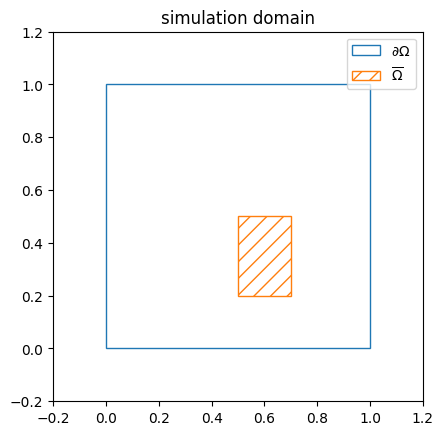

In [3]:
plot_domain(Ω, dΩ)

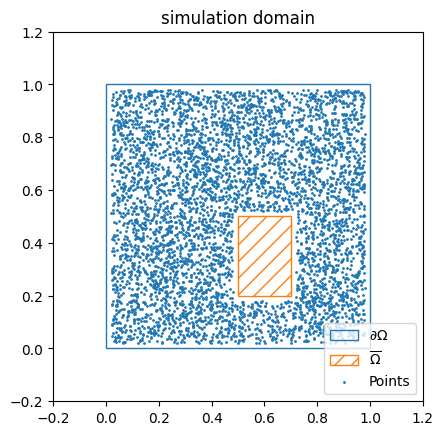

In [4]:
n_points = 5_000

Pts = generate_domain_points(n_points, Ω, dΩ)
plot_domain_wpoints(Ω, dΩ, Pts)

In [5]:
n_points = 500
dΩ_Pts_out = generate_boundary_points(n_points, Ω)
dΩ_Pts_in = dΩ.generate_surface_points(n_points)

In [9]:
np.max(dΩ_Pts_in)

0.6999828738657978

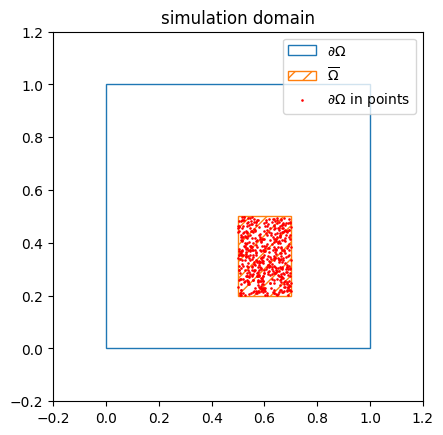

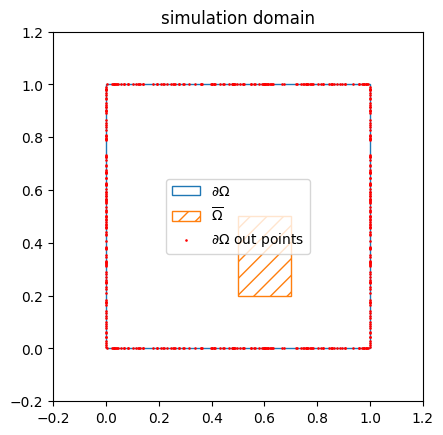

In [6]:
pts_plot_props = {
    "s": 3,
    "c": "red",
    "marker": ".",
    "label": "$\partial\Omega$ in points",
}
plot_domain_wpoints(Ω, dΩ, dΩ_Pts_in, pts_visual=pts_plot_props)

pts_plot_props = {
    "s": 3,
    "c": "red",
    "marker": ".",
    "label": "$\partial\Omega$ out points",
}
plot_domain_wpoints(Ω, dΩ, dΩ_Pts_out, pts_visual=pts_plot_props)

**Create analytic solution**

In [14]:
x_min_max_y_min_max_Ω = [int(coord * 100) for coord in Ω.boundary_points()]
x_min_Ω, x_max_Ω, y_min_Ω, y_max_Ω = x_min_max_y_min_max_Ω
print(x_min_Ω, x_max_Ω, y_min_Ω, y_max_Ω)

-100 200 -100 200


In [21]:
Nx = x_max_Ω
Ny = y_max_Ω
x = np.linspace(x_min_Ω, x_max_Ω, num=Nx + 2, endpoint=True)
y = np.linspace(y_min_Ω, y_max_Ω, num=Ny + 2, endpoint=True)

A = np.zeros((Nx, Ny))

# boundary:
x_min_max_y_min_max_dΩ = [int(coord * 100) for coord in dΩ.boundary_points()]
x_min_dΩ, x_max_dΩ, y_min_dΩ, y_max_dΩ = x_min_max_y_min_max_dΩ
print(x_min_dΩ, x_max_dΩ, y_min_dΩ, y_max_dΩ)
A[x_min_dΩ + 50 : x_max_dΩ + 25, y_min_dΩ + 50 : y_max_dΩ + 25] = 1.0

0 100 0 100


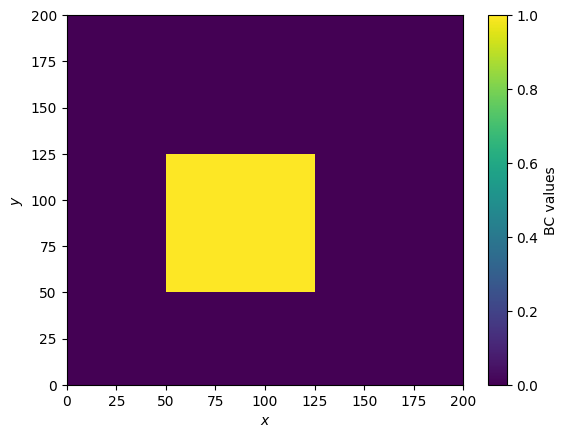

In [22]:
plt.pcolormesh(A.T)
plt.colorbar(label="BC values")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

In [23]:
convergence = 1e-4
maxsteps = 1_000
iterations = 0
diff = convergence + 1

Nx = A.shape[1]
Ny = A.shape[0]

while iterations < maxsteps or diff > convergence:
    # Loop over all *INNER* points and relax
    Atemp = A.copy()
    diff = 0.0

    for y in range(1, Ny - 1):
        for x in range(1, Nx - 1):
            A[y, x] = 0.25 * (
                Atemp[y, x + 1] + Atemp[y, x - 1] + Atemp[y + 1, x] + Atemp[y - 1, x]
            )
            diff += np.abs(A[y, x] - Atemp[y, x])

    diff /= Nx * Ny
    iterations += 1

print("Error", diff)

Error 6.81652150100161e-05


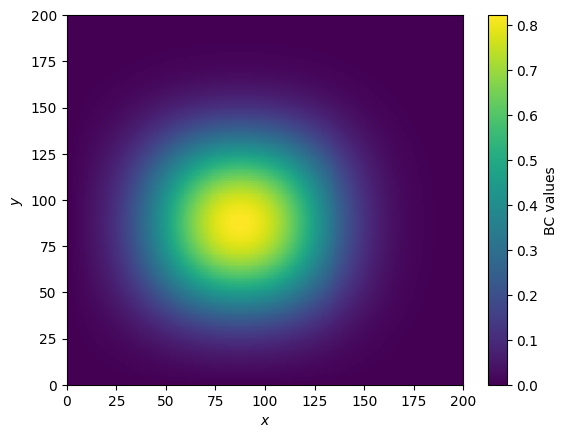

In [24]:
plt.pcolormesh(A)
plt.colorbar(label="BC values")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()